Imports

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Finding the Areas of Interest with a quantile over all 110 hurricanes.

In [2]:
def tp_quantile(directory):

    tp_values = []
    files = [f for f in os.listdir(directory) if f.endswith('.grib')]
    
    for name in files:

        filepath = os.path.join(directory, name)
        
        rainfall = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [228]}}).to_dataframe()
        vals = rainfall.tp

        tp_values.append(vals)

    return tp_values

In [3]:
%%capture

tp_arrays = tp_quantile("..\data_grib")

In [4]:
tp_values = pd.concat([arr for arr in tp_arrays])

In [5]:
tp_95_quantile = tp_values.quantile(0.95)

In [6]:
tp_95_quantile

np.float32(0.0013141632)

The 95% tp quantile is 0.0013141632

In [7]:
def ws10_quantile(directory):

    ws10_values = []
    files = [f for f in os.listdir(directory) if f.endswith('.grib')]
    
    for name in files:

        filepath = os.path.join(directory, name)
        
        speeds = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [165, 166]}}).to_dataframe()
        u_speed = speeds.u10
        v_speed = speeds.v10
        ws10 = np.sqrt(u_speed**2 + v_speed**2)

        ws10_values.append(ws10)

    return ws10_values

In [8]:
%%capture

ws10_arrays = ws10_quantile("../data_grib")

In [9]:
ws10_values = pd.concat([arr for arr in ws10_arrays])

In [10]:
ws10_95_quantile = ws10_values.quantile(0.95)

In [11]:
ws10_95_quantile

np.float64(11.48831558227539)

The ws10 95% quantile is 11.48831558227539

EDA for Hurricane Abby

In [12]:
speeds = xr.open_dataset("../data_grib/ABBY_1968_07.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [165, 166]}})
rainfall = xr.open_dataset("../data_grib/ABBY_1968_07.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [228]}})
extra = xr.open_dataset("../data_grib/ABBY_1968_07.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [134, 34]}})

Ignoring index file '../data_grib/ABBY_1968_07.grib.5b7b6.idx' incompatible with GRIB file
Ignoring index file '../data_grib/ABBY_1968_07.grib.5b7b6.idx' incompatible with GRIB file
Ignoring index file '../data_grib/ABBY_1968_07.grib.5b7b6.idx' incompatible with GRIB file


In [13]:
speeds = speeds.to_dataframe()
rainfall = rainfall.to_dataframe()
extra = extra.to_dataframe()

In [14]:
u_speed = speeds.u10
v_speed = speeds.v10
ws10 = np.sqrt(u_speed**2 + v_speed**2)

speeds["ws10"] = ws10

In [15]:
mask_ws10 = speeds['ws10'] > ws10_95_quantile
mask_tp = rainfall['tp'] > tp_95_quantile

In [16]:
#Finding the coordinates that experience weather above the thresholds at some point

temp = mask_ws10.groupby(["latitude", "longitude"]).sum()
mask_ws10_average = temp > 0

temp = mask_tp.groupby(["latitude", "longitude"]).sum()
mask_tp_average = temp > 0

In [17]:
#Averaging wind speed and tp over time

ws10_average = speeds["ws10"].groupby(["latitude", "longitude"]).mean()
tp_average = rainfall["tp"].groupby(["latitude", "longitude"]).mean()

In [18]:
combined_mask = mask_ws10_average & mask_tp_average

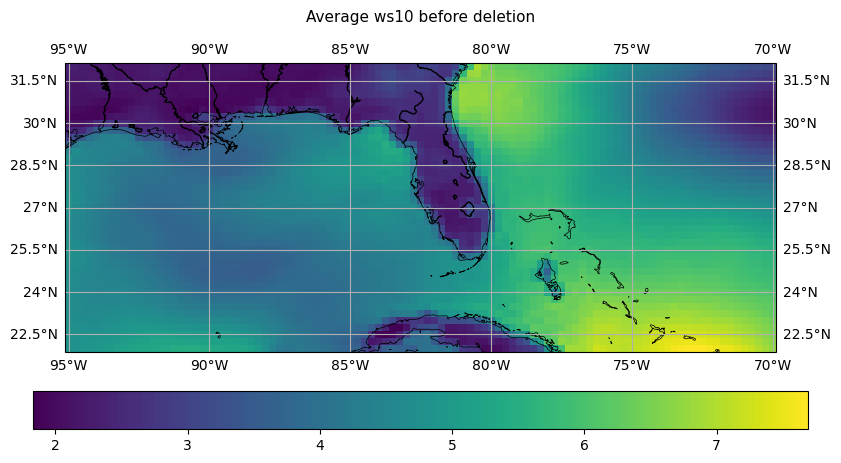

In [19]:
temp = ws10_average.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
#cbar.set_label('Average ws10 before deletion')

# Add gridlines
ax.gridlines(draw_labels=True)



ax.set_title(f'Average ws10 before deletion', fontsize=11, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

# Show the plot
plt.show()


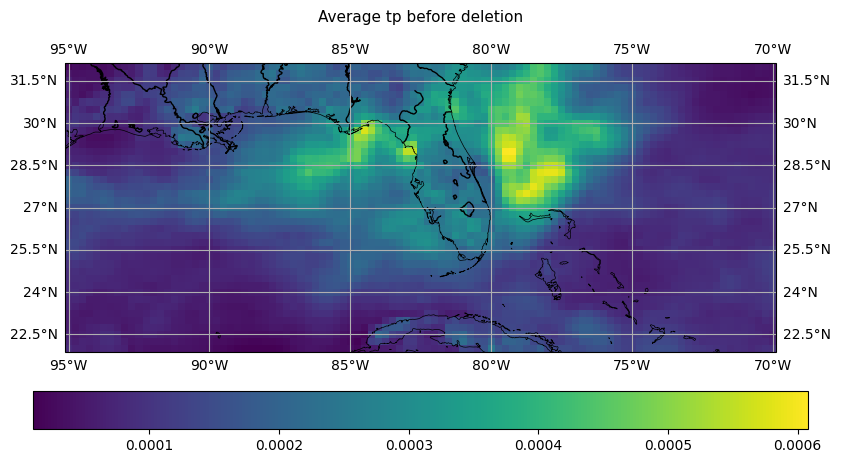

In [20]:
temp = tp_average.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
#cbar.set_label('Average ws10 before deletion')

# Add gridlines
ax.gridlines(draw_labels=True)



ax.set_title(f'Average tp before deletion', fontsize=11, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

# Show the plot
plt.show()

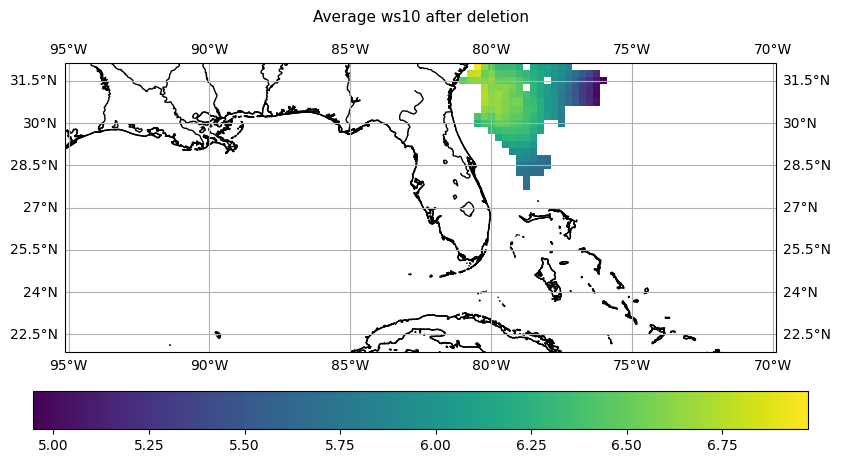

In [21]:
temp = ws10_average.where(combined_mask).unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
#cbar.set_label()

# Add gridlines
ax.gridlines(draw_labels=True)



ax.set_title(f'Average ws10 after deletion', fontsize=11, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

# Show the plot
plt.show()

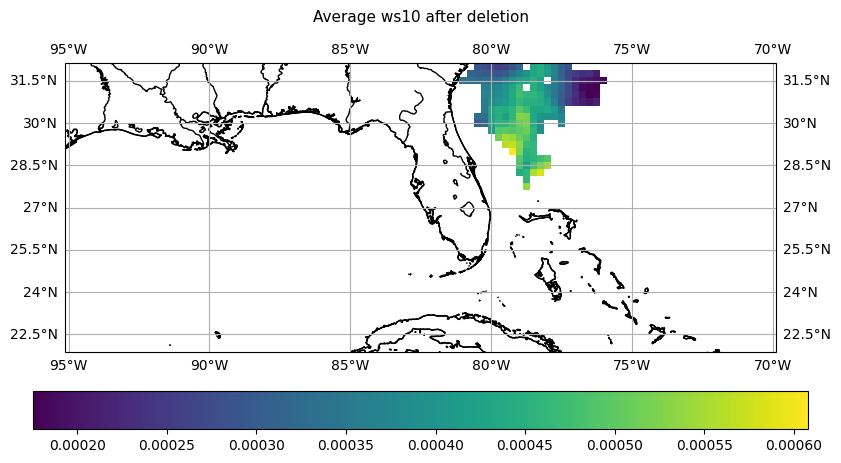

In [22]:
temp = tp_average.where(combined_mask).unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
#cbar.set_label()

# Add gridlines
ax.gridlines(draw_labels=True)



ax.set_title(f'Average ws10 after deletion', fontsize=11, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

# Show the plot
plt.show()

In [23]:
sp_average = extra["sp"].groupby(["latitude", "longitude"]).mean()
sst_average = extra["sst"].groupby(["latitude", "longitude"]).mean()

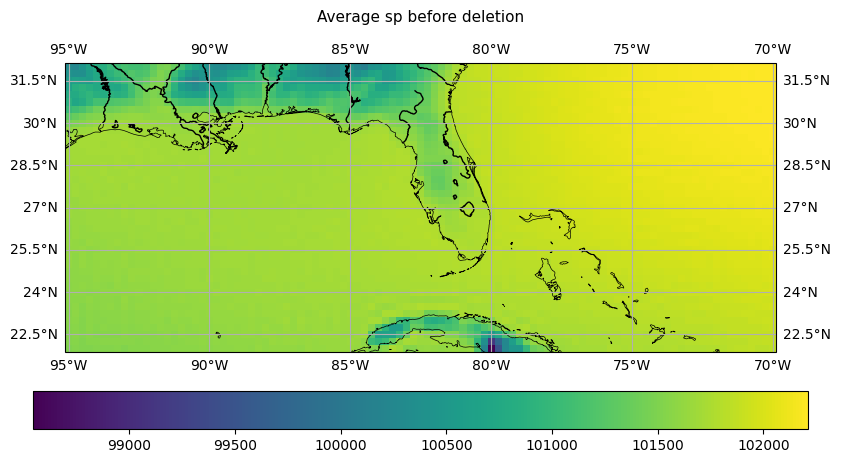

In [24]:
temp = sp_average.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
#cbar.set_label()

# Add gridlines
ax.gridlines(draw_labels=True)



ax.set_title(f'Average sp before deletion', fontsize=11, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

# Show the plot
plt.show()

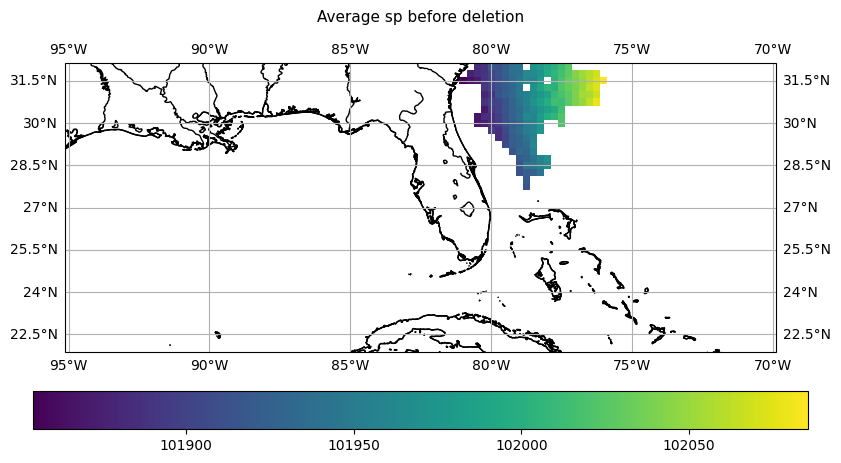

In [25]:
temp = sp_average.where(combined_mask).unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
#cbar.set_label()

# Add gridlines
ax.gridlines(draw_labels=True)



ax.set_title(f'Average sp before deletion', fontsize=11, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

# Show the plot
plt.show()

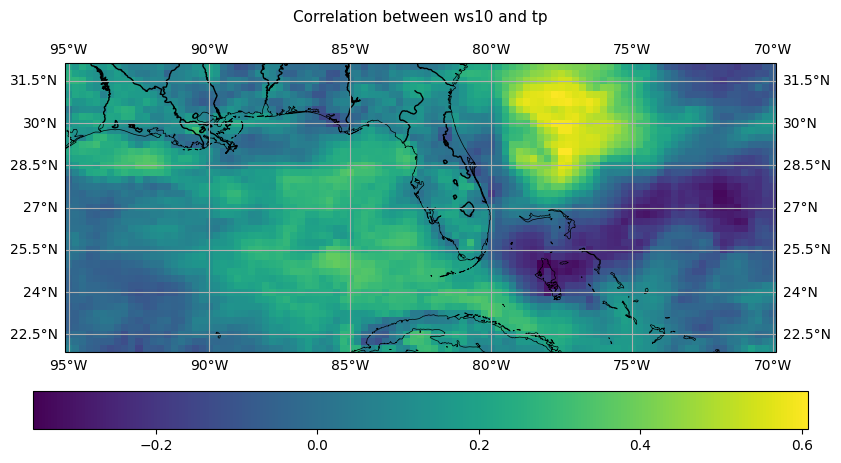

In [26]:

test = rainfall.droplevel(level=[0,1])
vals = test.set_index([test.valid_time, test.index])
vals = vals.rename_axis(index={"valid_time":"time"})


df_combined = pd.merge(speeds.ws10, vals.tp, on = ['time','latitude','longitude'], how='inner')

correlations = df_combined.groupby(["latitude","longitude"]).apply(lambda x: x['ws10'].corr(x['tp']))

temp = correlations.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values
fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
#cbar.set_label('Spatial Correlation')

# Add gridlines
ax.gridlines(draw_labels=True)



ax.set_title(f'Correlation between ws10 and tp', fontsize=11, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

# Show the plot
plt.show()



Hurricane Abby was Cat 1. Lets analyse a more serious hurricane such as Andrew which was Cat 5.

EDA for Hurricane Andrew.

In [37]:
speeds = xr.open_dataset("../data_grib/ANDEREW_1992_08.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [165, 166]}})
rainfall = xr.open_dataset("../data_grib/ANDEREW_1992_08.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [228]}})
extra = xr.open_dataset("../data_grib/ANDEREW_1992_08.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [134, 34]}})

Ignoring index file '../data_grib/ANDEREW_1992_08.grib.5b7b6.idx' incompatible with GRIB file
Ignoring index file '../data_grib/ANDEREW_1992_08.grib.5b7b6.idx' incompatible with GRIB file
Ignoring index file '../data_grib/ANDEREW_1992_08.grib.5b7b6.idx' incompatible with GRIB file


In [38]:
speeds = speeds.to_dataframe()
rainfall = rainfall.to_dataframe()
extra = extra.to_dataframe()

In [39]:
u_speed = speeds.u10
v_speed = speeds.v10
ws10 = np.sqrt(u_speed**2 + v_speed**2)

speeds["ws10"] = ws10

In [40]:
mask_ws10 = speeds['ws10'] > ws10_95_quantile
mask_tp = rainfall['tp'] > tp_95_quantile

In [41]:
#Finding the coordinates that experience weather above the thresholds at some point

temp = mask_ws10.groupby(["latitude", "longitude"]).sum()
mask_ws10_average = temp > 0

temp = mask_tp.groupby(["latitude", "longitude"]).sum()
mask_tp_average = temp > 0

In [42]:
#Averaging wind speed and tp over time

ws10_average = speeds["ws10"].groupby(["latitude", "longitude"]).mean()
tp_average = rainfall["tp"].groupby(["latitude", "longitude"]).mean()

In [43]:
combined_mask = mask_ws10_average & mask_tp_average

In [44]:
sp_average = extra["sp"].groupby(["latitude", "longitude"]).mean()
sst_average = extra["sst"].groupby(["latitude", "longitude"]).mean()

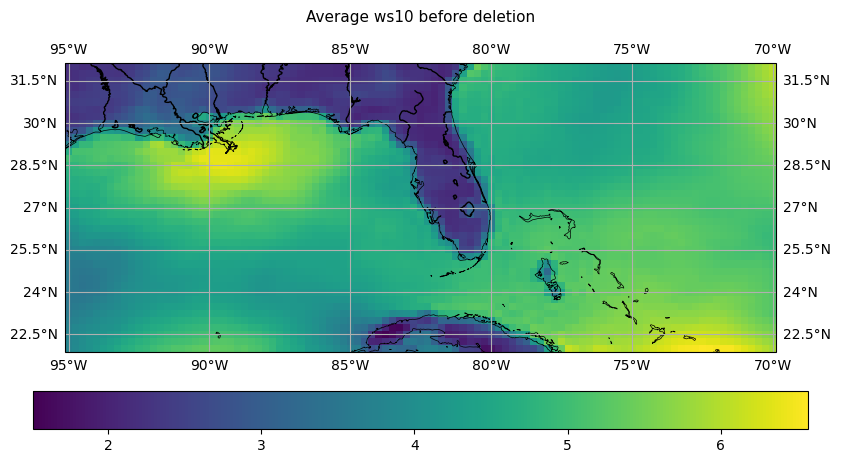

In [46]:
temp = ws10_average.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
#cbar.set_label()

# Add gridlines
ax.gridlines(draw_labels=True)



ax.set_title(f'Average ws10 before deletion', fontsize=11, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

# Show the plot
plt.show()

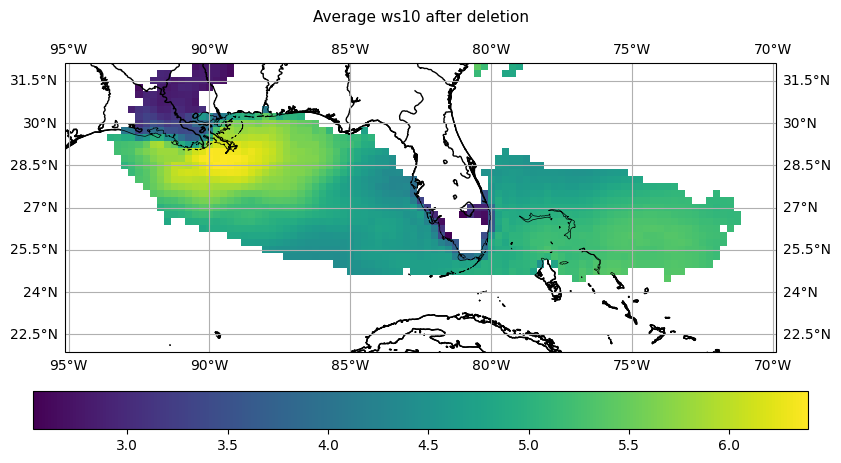

In [47]:
temp = ws10_average.where(combined_mask).unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
#cbar.set_label()

# Add gridlines
ax.gridlines(draw_labels=True)



ax.set_title(f'Average ws10 after deletion', fontsize=11, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

# Show the plot
plt.show()

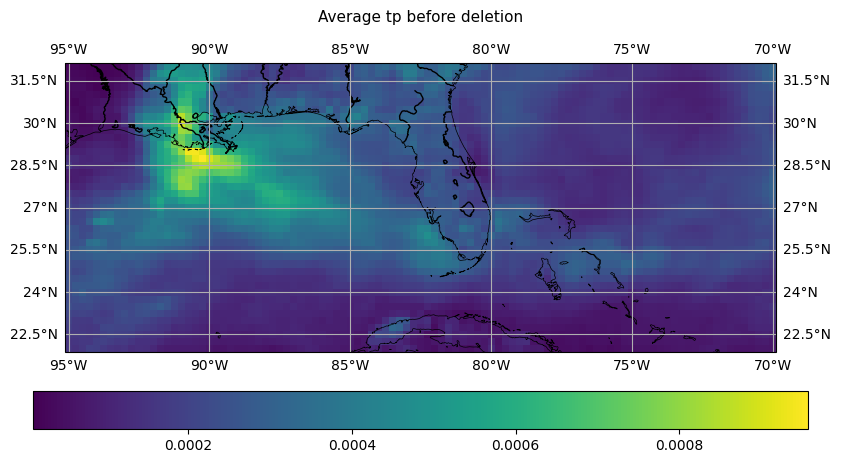

In [50]:
temp = tp_average.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
#cbar.set_label()

# Add gridlines
ax.gridlines(draw_labels=True)



ax.set_title(f'Average tp before deletion', fontsize=11, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

# Show the plot
plt.show()

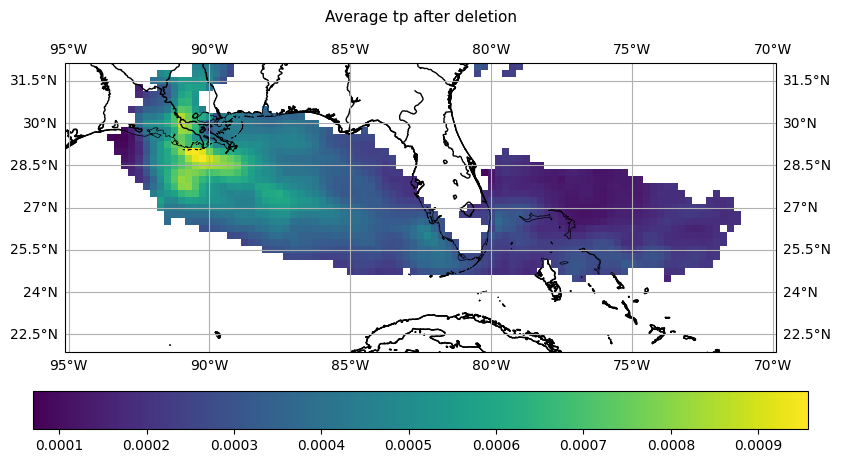

In [52]:
temp = tp_average.where(combined_mask).unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
#cbar.set_label()

# Add gridlines
ax.gridlines(draw_labels=True)



ax.set_title(f'Average tp after deletion', fontsize=11, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

# Show the plot
plt.show()

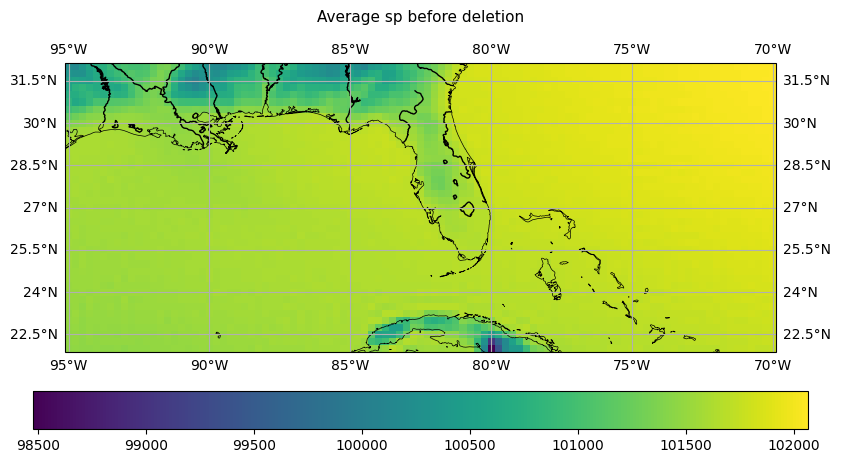

In [51]:
temp = sp_average.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
#cbar.set_label()

# Add gridlines
ax.gridlines(draw_labels=True)



ax.set_title(f'Average sp before deletion', fontsize=11, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

# Show the plot
plt.show()

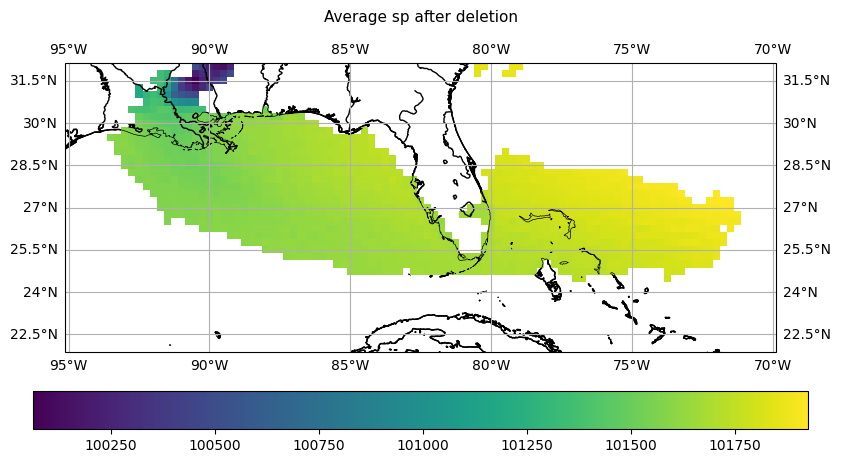

In [53]:
temp = sp_average.where(combined_mask).unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
#cbar.set_label()

# Add gridlines
ax.gridlines(draw_labels=True)



ax.set_title(f'Average sp after deletion', fontsize=11, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

# Show the plot
plt.show()

Much more area experiences an extreme weather event.

What quantile to use?

In [68]:
def retained_data(speed_data, rainfall_data, ws10_threshold, tp_threshold):

    speed_data = speed_data.to_dataframe()
    rainfall_data = rainfall_data.to_dataframe()

    u_speed = speed_data.u10
    v_speed = speed_data.v10
    ws10 = np.sqrt(u_speed**2 + v_speed**2)

    speed_data["ws10"] = ws10

    mask_ws10 = speed_data['ws10'] > ws10_threshold
    mask_tp = rainfall_data['tp'] > tp_threshold

    temp = mask_ws10.groupby(["latitude", "longitude"]).sum()
    mask_ws10_average = temp > 0

    temp = mask_tp.groupby(["latitude", "longitude"]).sum()
    mask_tp_average = temp > 0

    combined_mask = mask_ws10_average & mask_tp_average

    return combined_mask.sum() / len(combined_mask)

In [69]:
retained_data(speeds, rainfall, ws10_threshold, tp_threshold)

np.float64(0.6157932866457377)

In [79]:
%%capture

retained_values = []
files = [f for f in os.listdir("../data_grib") if f.endswith('.grib')]

ws10_threshold = ws10_values.quantile(0.95)
tp_threshold = tp_values.quantile(0.95)
    
for name in files:

    filepath = os.path.join("../data_grib", name)
        
    rainfall = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [228]}})
    speeds = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [165, 166]}})

    vals = retained_data(speeds, rainfall, ws10_threshold, tp_threshold)

    retained_values.append(vals)

In [80]:
retained_95 = sum(retained_values)/len(retained_values)
retained_95

np.float64(0.28919717875908707)

In [77]:
%%capture

retained_values_90 = []
files = [f for f in os.listdir("../data_grib") if f.endswith('.grib')]

ws10_threshold = ws10_values.quantile(0.90)
tp_threshold = tp_values.quantile(0.90)
    
for name in files:

    filepath = os.path.join("../data_grib", name)
        
    rainfall = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [228]}})
    speeds = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [165, 166]}})

    vals = retained_data(speeds, rainfall, ws10_threshold, tp_threshold)

    retained_values_90.append(vals)

In [78]:
retained_90 = sum(retained_values_90)/len(retained_values_90)
retained_90

np.float64(0.44265336542064637)

In [83]:
%%capture

retained_values_97 = []
files = [f for f in os.listdir("../data_grib") if f.endswith('.grib')]

ws10_threshold = ws10_values.quantile(0.97)
tp_threshold = tp_values.quantile(0.97)
    
for name in files:

    filepath = os.path.join("../data_grib", name)
        
    rainfall = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [228]}})
    speeds = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [165, 166]}})

    vals = retained_data(speeds, rainfall, ws10_threshold, tp_threshold)

    retained_values_97.append(vals)

In [84]:
retained_97 = sum(retained_values_97)/len(retained_values_97)
retained_97

np.float64(0.209641182789431)

In [91]:
%%capture

retained_values_92 = []
files = [f for f in os.listdir("../data_grib") if f.endswith('.grib')]

ws10_threshold = ws10_values.quantile(0.92)
tp_threshold = tp_values.quantile(0.92)
    
for name in files:

    filepath = os.path.join("../data_grib", name)
        
    rainfall = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [228]}})
    speeds = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [165, 166]}})

    vals = retained_data(speeds, rainfall, ws10_threshold, tp_threshold)

    retained_values_92.append(vals)

In [92]:
retained_92 = sum(retained_values_92)/len(retained_values_92)
retained_92

np.float64(0.3862302125923273)

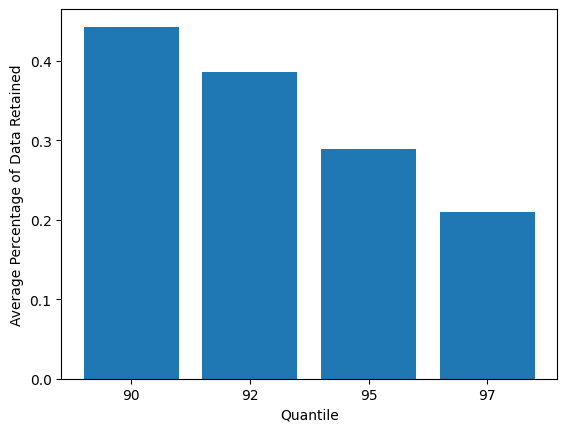

In [94]:
plt.bar(x=["90","92","95", "97"], height=[retained_90, retained_92, retained_95, retained_97])
plt.xlabel("Quantile")
plt.ylabel("Average Percentage of Data Retained");

Correlation Plots

In [54]:
test = rainfall.droplevel(level=[0,1])
vals = test.set_index([test.valid_time, test.index])
vals = vals.rename_axis(index={"valid_time":"time"})
vals

number  surface          valid_time  \
time                latitude longitude                                        
1992-08-15 19:00:00 32.0     -95.00          0      0.0 1992-08-15 19:00:00   
                             -94.75          0      0.0 1992-08-15 19:00:00   
                             -94.50          0      0.0 1992-08-15 19:00:00   
                             -94.25          0      0.0 1992-08-15 19:00:00   
                             -94.00          0      0.0 1992-08-15 19:00:00   
...                                        ...      ...                 ...   
1992-08-29 06:00:00 22.0     -71.00          0      0.0 1992-08-29 06:00:00   
                             -70.75          0      0.0 1992-08-29 06:00:00   
                             -70.50          0      0.0 1992-08-29 06:00:00   
                             -70.25          0      0.0 1992-08-29 06:00:00   
                             -70.00          0      0.0 1992-08-29 06:00:00   

                                        tp  
time                latitude longitude      
1992-08-15 19:00:00 32.0     -95.00    NaN  
                             -94.75    NaN  
                             -94.50    NaN  
                             -94.25    NaN  
                             -94.00    NaN  
...                                     ..  
1992-08-29 06:00:00 22.0     -71.00    NaN  
                             -70.75    NaN  
                             -70.50    NaN  
                             -70.25    NaN  
                             -70.00    NaN  

[1341684 rows x 4 columns]

In [55]:
speeds

number   step  surface  \
time                latitude longitude                           
1992-08-16 00:00:00 32.0     -95.00          0 0 days      0.0   
                             -94.75          0 0 days      0.0   
                             -94.50          0 0 days      0.0   
                             -94.25          0 0 days      0.0   
                             -94.00          0 0 days      0.0   
...                                        ...    ...      ...   
1992-08-28 23:00:00 22.0     -71.00          0 0 days      0.0   
                             -70.75          0 0 days      0.0   
                             -70.50          0 0 days      0.0   
                             -70.25          0 0 days      0.0   
                             -70.00          0 0 days      0.0   

                                                valid_time       u10  \
time                latitude longitude                                 
1992-08-16 00:00:00 32.0     -95.00    1992-08-16 00:00:00 -1.589447   
                             -94.75    1992-08-16 00:00:00 -1.637299   
                             -94.50    1992-08-16 00:00:00 -1.506439   
                             -94.25    1992-08-16 00:00:00 -1.211517   
                             -94.00    1992-08-16 00:00:00 -0.703705   
...                                                    ...       ...   
1992-08-28 23:00:00 22.0     -71.00    1992-08-28 23:00:00 -7.080612   
                             -70.75    1992-08-28 23:00:00 -6.873581   
                             -70.50    1992-08-28 23:00:00 -6.606003   
                             -70.25    1992-08-28 23:00:00 -6.418503   
                             -70.00    1992-08-28 23:00:00 -6.369675   

                                             v10      ws10  
time                latitude longitude                      
1992-08-16 00:00:00 32.0     -95.00    -2.500549  2.962953  
                             -94.75    -2.551331  3.031507  
                             -94.50    -2.525940  2.941043  
                             -94.25    -2.658752  2.921770  
                             -94.00    -2.876526  2.961351  
...                                          ...       ...  
1992-08-28 23:00:00 22.0     -71.00     1.306427  7.200126  
                             -70.75     1.105255  6.961875  
                             -70.50     0.845490  6.659889  
                             -70.25     0.615997  6.447994  
                             -70.00     0.392365  6.381748  

[1291992 rows x 7 columns]

In [56]:
df_combined = pd.merge(speeds.ws10, vals.tp, on = ['time','latitude','longitude'], how='inner')

In [57]:
df_combined

ws10            tp
time                latitude longitude                        
1992-08-16 00:00:00 32.0     -95.00     2.962953  0.000000e+00
                             -94.75     3.031507  0.000000e+00
                             -94.50     2.941043  0.000000e+00
                             -94.25     2.921770  0.000000e+00
                             -94.00     2.961351  0.000000e+00
...                                          ...           ...
1992-08-28 23:00:00 22.0     -71.00     7.200126  0.000000e+00
                             -70.75     6.961875  0.000000e+00
                             -70.50     6.659889  0.000000e+00
                             -70.25     6.447994  0.000000e+00
                             -70.00     6.381748  4.768372e-07

[1291992 rows x 2 columns]

In [58]:
correlations = df_combined.groupby(["latitude","longitude"]).apply(lambda x: x['ws10'].corr(x['tp']))

In [59]:
correlations

latitude  longitude
22.0      -95.00      -0.156725
          -94.75      -0.143532
          -94.50      -0.140599
          -94.25      -0.079672
          -94.00      -0.077665
                         ...   
32.0      -71.00       0.005438
          -70.75      -0.025318
          -70.50       0.012192
          -70.25       0.052087
          -70.00       0.084423
Length: 4141, dtype: float64

In [70]:
temp = correlations.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

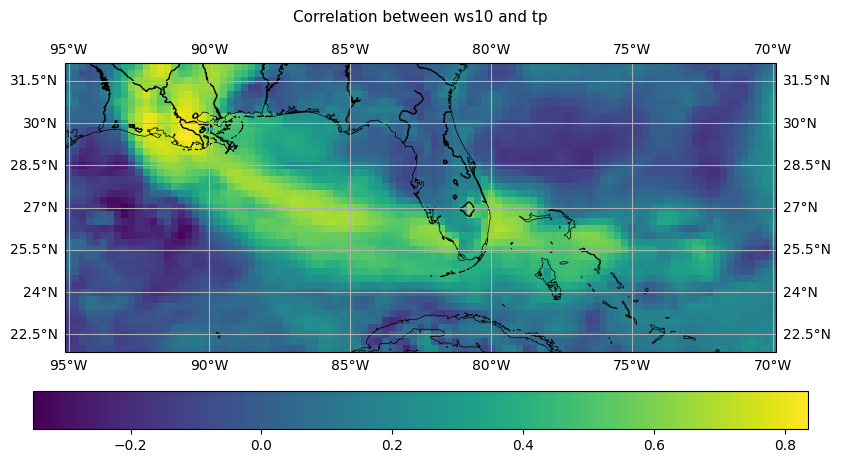

In [71]:
fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
#cbar.set_label('Spatial Correlation')

# Add gridlines
ax.gridlines(draw_labels=True)



ax.set_title(f'Correlation between ws10 and tp', fontsize=11, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

# Show the plot
plt.show()



In [64]:
df_temp = pd.merge(df_combined, extra.sp, on=['time','latitude','longitude'], how='left')
df_complete = pd.merge(df_temp, extra.sst, on=['time','latitude','longitude'], how='left')

In [65]:
df_complete

ws10            tp         sp  \
time                latitude longitude                                      
1992-08-16 00:00:00 32.0     -95.00     2.962953  0.000000e+00  100293.25   
                             -94.75     3.031507  0.000000e+00  100250.25   
                             -94.50     2.941043  0.000000e+00  100467.25   
                             -94.25     2.921770  0.000000e+00  100677.25   
                             -94.00     2.961351  0.000000e+00  100807.25   
...                                          ...           ...        ...   
1992-08-28 23:00:00 22.0     -71.00     7.200126  0.000000e+00  101833.25   
                             -70.75     6.961875  0.000000e+00  101845.25   
                             -70.50     6.659889  0.000000e+00  101825.25   
                             -70.25     6.447994  0.000000e+00  101814.25   
                             -70.00     6.381748  4.768372e-07  101831.25   

                                               sst  
time                latitude longitude              
1992-08-16 00:00:00 32.0     -95.00            NaN  
                             -94.75            NaN  
                             -94.50            NaN  
                             -94.25            NaN  
                             -94.00            NaN  
...                                            ...  
1992-08-28 23:00:00 22.0     -71.00     301.797363  
                             -70.75     301.750488  
                             -70.50     301.694824  
                             -70.25     301.687988  
                             -70.00     301.735840  

[1291992 rows x 4 columns]

In [68]:
ws10_sp_corr = df_complete.groupby(["latitude","longitude"]).apply(lambda x: x['ws10'].corr(x['sp']))
tp_sp_corr = df_complete.groupby(["latitude","longitude"]).apply(lambda x: x['sp'].corr(x['tp']))

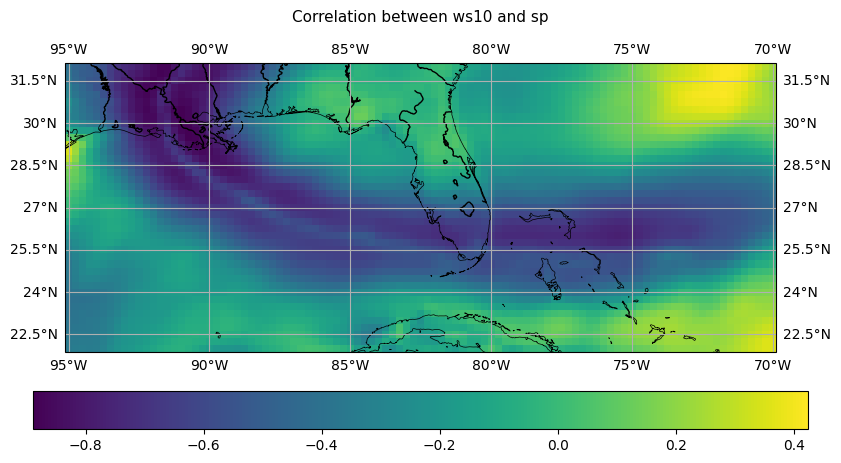

In [72]:

temp = ws10_sp_corr.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
#cbar.set_label('Spatial Correlation')

# Add gridlines
ax.gridlines(draw_labels=True)



ax.set_title(f'Correlation between ws10 and sp', fontsize=11, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

# Show the plot
plt.show()

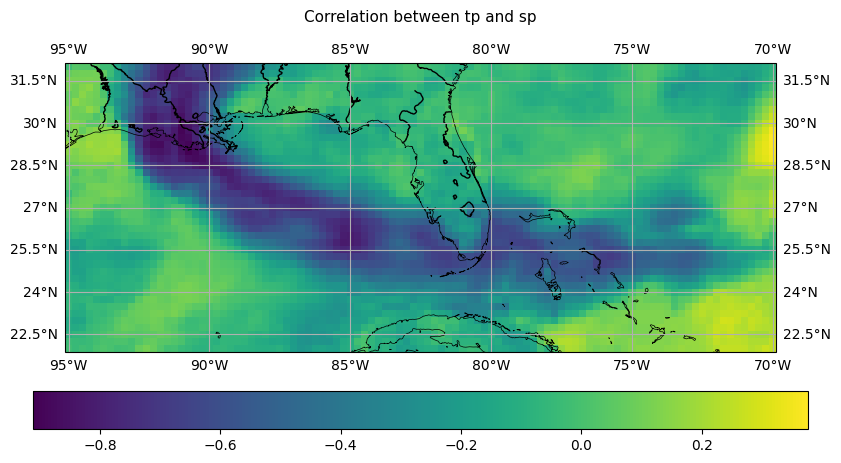

In [74]:
temp = tp_sp_corr.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
#cbar.set_label('Spatial Correlation')

# Add gridlines
ax.gridlines(draw_labels=True)



ax.set_title(f'Correlation between tp and sp', fontsize=11, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

# Show the plot
plt.show()

Temporal Filtering

In [86]:
specific_point= df_complete.loc[:,30.0,-92.0]

In [87]:
specific_point

,ws10,tp,sp,sst
time,,,,
1992-08-16 00:00:00,2.469299,0.000000,101548.2500,NaN
1992-08-16 01:00:00,2.707053,0.000000,101542.1250,NaN
1992-08-16 02:00:00,3.471244,0.000000,101590.5000,NaN
1992-08-16 03:00:00,4.238440,0.000000,101672.8750,NaN
1992-08-16 04:00:00,4.624816,0.000000,101706.2500,NaN
...,...,...,...,...
1992-08-28 19:00:00,3.812908,0.000029,101636.9375,NaN
1992-08-28 20:00:00,3.923162,0.000007,101558.3750,NaN
1992-08-28 21:00:00,3.914272,0.000002,101503.0000,NaN


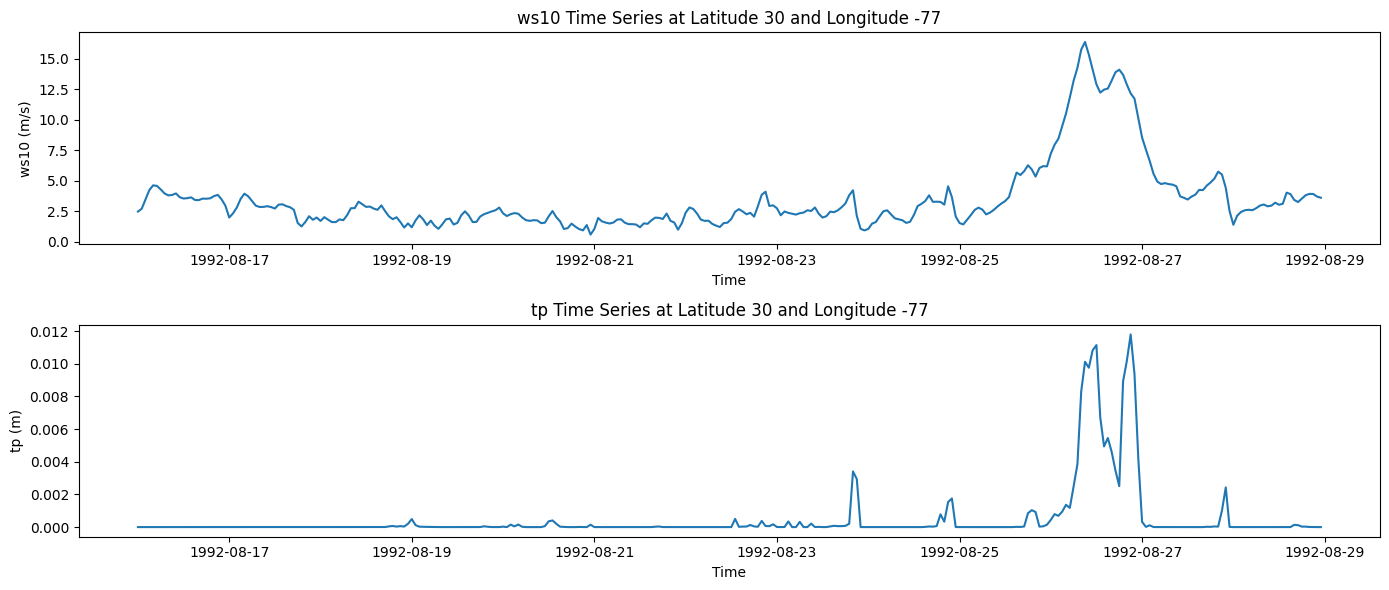

In [88]:
plt.figure(figsize=(14,6))
plt.subplot(211)
plt.plot(specific_point.ws10)
plt.title('ws10 Time Series at Latitude 30 and Longitude -77')
plt.xlabel('Time')
plt.ylabel('ws10 (m/s)')

plt.subplot(212)
plt.plot(specific_point.tp)
plt.title('tp Time Series at Latitude 30 and Longitude -77')
plt.xlabel('Time')
plt.ylabel('tp (m)')

plt.tight_layout()
plt.show();

In [89]:
ws10_quant = ws10_values.quantile(0.9)
tp_quant = tp_values.quantile(0.9)

In [90]:
extreme_ws10 = specific_point['ws10'] >= ws10_quant
extreme_tp = specific_point['tp'] >= tp_quant

In [91]:
extreme_periods = extreme_ws10 | extreme_tp

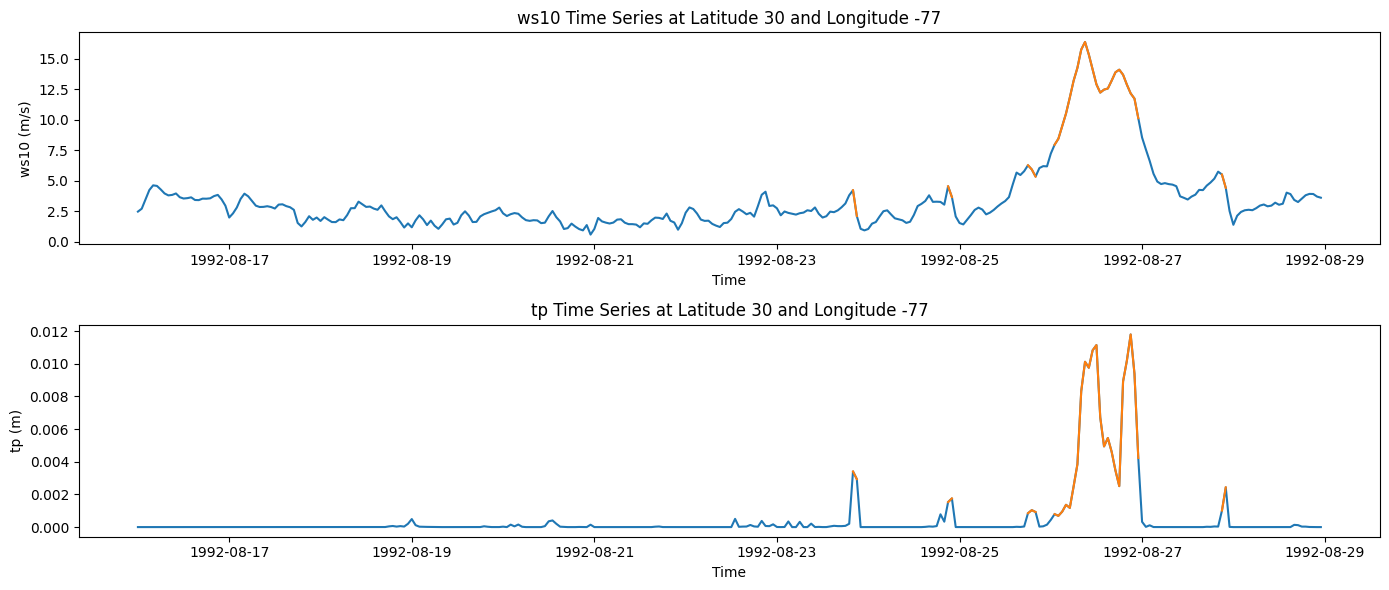

In [92]:
plt.figure(figsize=(14,6))
plt.subplot(211)
plt.plot(specific_point.ws10)
plt.plot(specific_point.ws10.where(extreme_periods))
plt.title('ws10 Time Series at Latitude 30 and Longitude -77')
plt.xlabel('Time')
plt.ylabel('ws10 (m/s)')

plt.subplot(212)
plt.plot(specific_point.tp)
plt.plot(specific_point.tp.where(extreme_periods))
plt.title('tp Time Series at Latitude 30 and Longitude -77')
plt.xlabel('Time')
plt.ylabel('tp (m)')

plt.tight_layout()
plt.show();

In [94]:
#Want to keep longest continuous segment

first_idx = extreme_periods.argmax().item()
last_idx = len(extreme_periods) - extreme_periods[::-1].argmax().item()

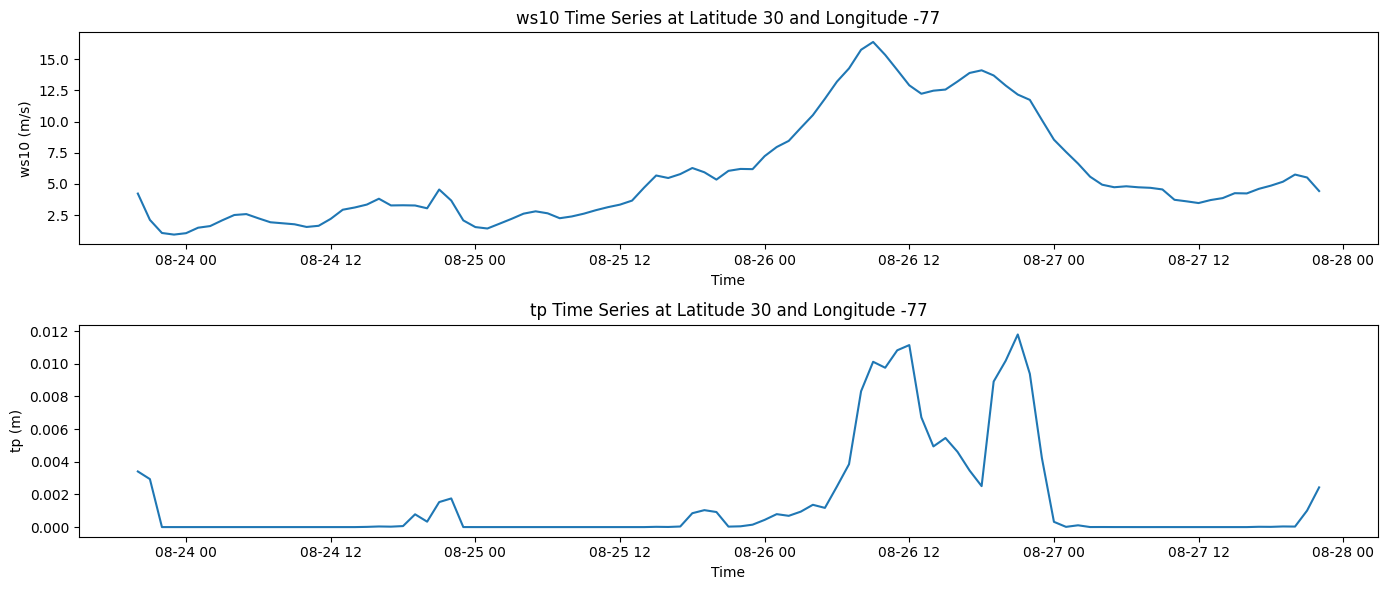

In [95]:
plt.figure(figsize=(14,6))
plt.subplot(211)
#plt.plot(specific_point.ws10)
plt.plot(specific_point.ws10[first_idx:last_idx])
plt.title('ws10 Time Series at Latitude 30 and Longitude -77')
plt.xlabel('Time')
plt.ylabel('ws10 (m/s)')

plt.subplot(212)
#plt.plot(specific_point.tp)
plt.plot(specific_point.tp[first_idx:last_idx])
plt.title('tp Time Series at Latitude 30 and Longitude -77')
plt.xlabel('Time')
plt.ylabel('tp (m)')

plt.tight_layout()
plt.show();

Now combine the spatial and temporal filter to calculate correlations.

In [96]:
df_combined

ws10            tp
time                latitude longitude                        
1992-08-16 00:00:00 32.0     -95.00     2.962953  0.000000e+00
                             -94.75     3.031507  0.000000e+00
                             -94.50     2.941043  0.000000e+00
                             -94.25     2.921770  0.000000e+00
                             -94.00     2.961351  0.000000e+00
...                                          ...           ...
1992-08-28 23:00:00 22.0     -71.00     7.200126  0.000000e+00
                             -70.75     6.961875  0.000000e+00
                             -70.50     6.659889  0.000000e+00
                             -70.25     6.447994  0.000000e+00
                             -70.00     6.381748  4.768372e-07

[1291992 rows x 2 columns]

In [97]:
latitude = df_combined.index.get_level_values("latitude").unique()
latitude

Index([ 32.0, 31.75,  31.5, 31.25,  31.0, 30.75,  30.5, 30.25,  30.0, 29.75,
        29.5, 29.25,  29.0, 28.75,  28.5, 28.25,  28.0, 27.75,  27.5, 27.25,
        27.0, 26.75,  26.5, 26.25,  26.0, 25.75,  25.5, 25.25,  25.0, 24.75,
        24.5, 24.25,  24.0, 23.75,  23.5, 23.25,  23.0, 22.75,  22.5, 22.25,
        22.0],
      dtype='float64', name='latitude')

In [98]:
longitude = df_combined.index.get_level_values("longitude").unique()
longitude

Index([ -95.0, -94.75,  -94.5, -94.25,  -94.0, -93.75,  -93.5, -93.25,  -93.0,
       -92.75,
       ...
       -72.25,  -72.0, -71.75,  -71.5, -71.25,  -71.0, -70.75,  -70.5, -70.25,
        -70.0],
      dtype='float64', name='longitude', length=101)

In [99]:
for lat in latitude:

    for lon in longitude:

        specific_point= df_complete.loc[:,lat,lon]

        extreme_ws10 = specific_point['ws10'] >= ws10_quant
        extreme_tp = specific_point['tp'] >= tp_quant
        extreme_periods = extreme_ws10 | extreme_tp

        first_idx = extreme_periods.argmax().item()
        last_idx = len(extreme_periods) - extreme_periods[::-1].argmax().item()

        corr = np.corrcoef(specific_point.ws10[first_idx:last_idx].values, specific_point.tp[first_idx:last_idx].values)[0,1]

        correlations.loc[lat,lon] = corr


c:\M4R\M4R_venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\M4R\M4R_venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\M4R\M4R_venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [100]:
correlations

latitude  longitude
22.0      -95.00      -0.259392
          -94.75      -0.251925
          -94.50      -0.252568
          -94.25      -0.165509
          -94.00      -0.172461
                         ...   
32.0      -71.00       0.011224
          -70.75      -0.032618
          -70.50       0.008409
          -70.25       0.050920
          -70.00       0.120944
Length: 4141, dtype: float64

In [105]:
correlations_filtered = correlations.where(combined_mask)

temp = correlations_filtered.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

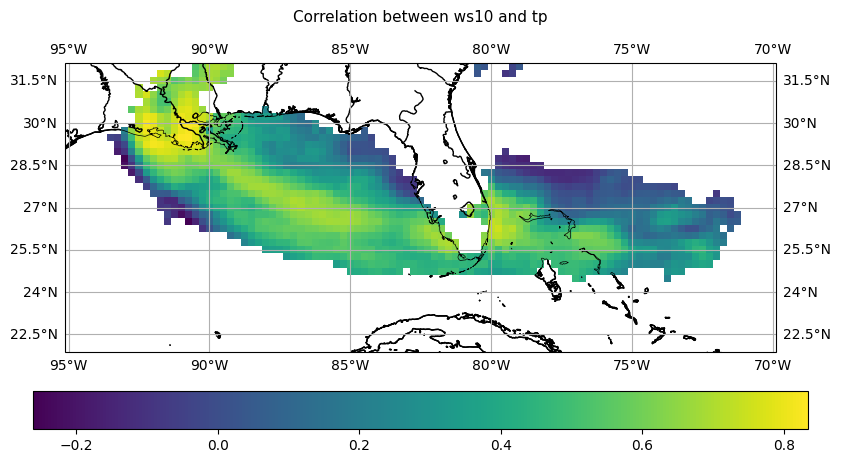

In [106]:
fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
#cbar.set_label('Spatial Correlation')

# Add gridlines
ax.gridlines(draw_labels=True)



ax.set_title(f'Correlation between ws10 and tp', fontsize=11, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

# Show the plot
plt.show()

c:\M4R\M4R_venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\M4R\M4R_venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\M4R\M4R_venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


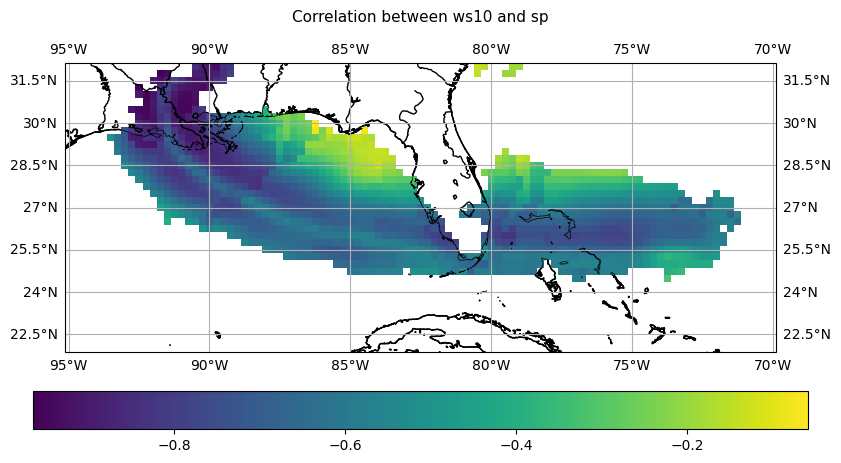

In [107]:
for lat in latitude:

    for lon in longitude:

        specific_point= df_complete.loc[:,lat,lon]

        extreme_ws10 = specific_point['ws10'] >= ws10_quant
        extreme_tp = specific_point['tp'] >= tp_quant
        extreme_periods = extreme_ws10 | extreme_tp

        first_idx = extreme_periods.argmax().item()
        last_idx = len(extreme_periods) - extreme_periods[::-1].argmax().item()

        corr = np.corrcoef(specific_point.ws10[first_idx:last_idx].values, specific_point.sp[first_idx:last_idx].values)[0,1]

        correlations.loc[lat,lon] = corr

correlations_filtered = correlations.where(combined_mask)

temp = correlations_filtered.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
#cbar.set_label('Spatial Correlation')

# Add gridlines
ax.gridlines(draw_labels=True)



ax.set_title(f'Correlation between ws10 and sp', fontsize=11, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

# Show the plot
plt.show()

c:\M4R\M4R_venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\M4R\M4R_venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\M4R\M4R_venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


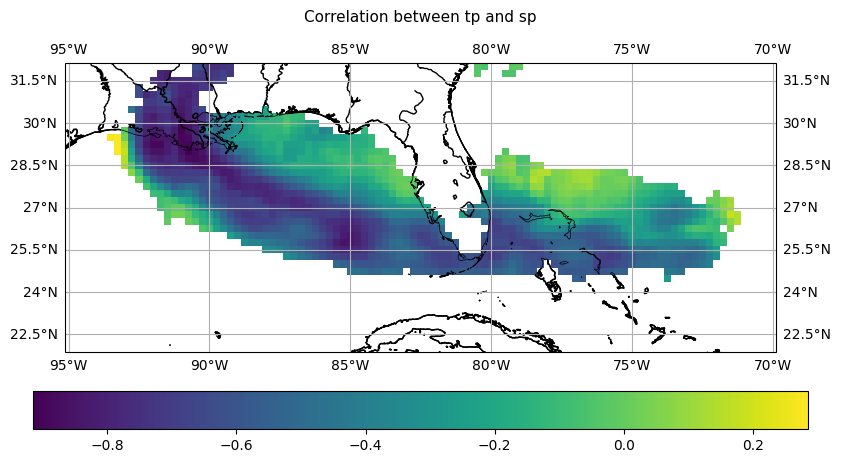

In [110]:
for lat in latitude:

    for lon in longitude:

        specific_point= df_complete.loc[:,lat,lon]

        extreme_ws10 = specific_point['ws10'] >= ws10_quant
        extreme_tp = specific_point['tp'] >= tp_quant
        extreme_periods = extreme_ws10 | extreme_tp

        first_idx = extreme_periods.argmax().item()
        last_idx = len(extreme_periods) - extreme_periods[::-1].argmax().item()

        corr = np.corrcoef(specific_point.tp[first_idx:last_idx].values, specific_point.sp[first_idx:last_idx].values)[0,1]

        correlations.loc[lat,lon] = corr

correlations_filtered = correlations.where(combined_mask)

temp = correlations_filtered.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
#cbar.set_label('Spatial Correlation')

# Add gridlines
ax.gridlines(draw_labels=True)



ax.set_title(f'Correlation between tp and sp', fontsize=11, pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

# Show the plot
plt.show()